In [ ]:
import torch
from torch import nn, optim
import torch.onnx
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

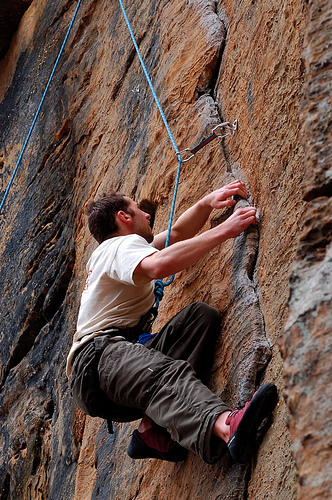

A man climbing a rock wall
A man climbing the side of a cliff .
A man is rock climbing .
Man with red shoes , white shirt and grey pants climbing .
The young man with the white t-shirt and jeans is rappeling up the rock wall .


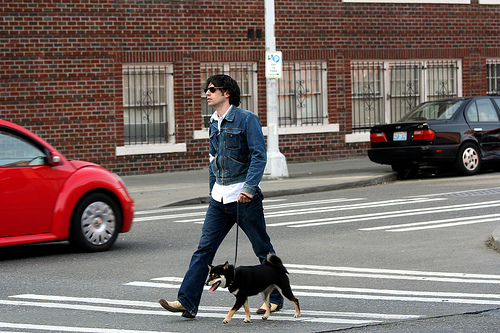

A man is walking a dog on a leash down the street
A man walking his dog in a crosswalk .
a man walks his dog in the street .
The man in the denim outfit walks a black and tan dog on a crosswalk .
Young man walking dog


In [4]:
import pandas as pd
import numpy as np
from PIL import Image
from IPython.display import display

# Paths
captions_file = '/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt'
images_path = '/kaggle/input/flickr8kimagescaptions/flickr8k/images'

# Load the captions file
captions = pd.read_csv(captions_file)

# Function to display random images with captions
def display_random_data(count=5, seed=1):
    np.random.seed(seed)
    # Randomly choose unique images
    images = np.random.choice(captions['image'].unique(), count, replace=False)
    # Display each image and its captions
    for image in images:
        # Display the image
        display(Image.open(f'{images_path}/{image}'))
        # Display all captions associated with the image
        img_captions = captions.loc[captions['image'] == image, 'caption'].tolist()
        for cap in img_captions:
            print(cap)

# Example usage
display_random_data(2)


In [1]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from torchvision import transforms

class My_Flickr8k(Dataset):
    def __init__(self, root_file, captions, transform=None):
        self.transform = transform
        self.root = root_file
        self.ids = captions  # DataFrame with image and caption columns

    def __getitem__(self, idx):
        # Extract the image filename and caption
        image_path, caption = self.ids.iloc[idx]
        image = Image.open(f"{self.root}/{image_path}").convert("RGB")  # Ensure it's RGB
        if self.transform: 
            image = self.transform(image)
        return image, caption

    def __len__(self):
        return len(self.ids)


In [2]:
def build_datasets_vocab(root_file, captions_file, transform, split=0.15):
    # Load the captions file
    df = pd.read_csv(captions_file)

    # Create a vocabulary dictionary
    vocab = {}
    def create_vocab(caption):
        # Tokenize captions and build the vocabulary
        tokens = [token.lower() for token in word_tokenize(caption)]
        for token in tokens:
            if token not in vocab:
                vocab[token] = len(vocab)

    # Apply vocabulary creation to all captions
    df["caption"].apply(create_vocab)

    # Split the data into train and validation sets
    train, valid = train_test_split(df, test_size=split, random_state=42)

    # Create dataset objects
    return My_Flickr8k(root_file, train, transform), \
           My_Flickr8k(root_file, valid, transform), \
           vocab


In [7]:
# # Define the root path for images and captions file path
# root_file = "/kaggle/input/flickr8kimagescaptions/flickr8k/images"
# captions_file = "/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt"

# # Define image transformations
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Resize images to 128x128
#     transforms.ToTensor()          # Convert images to tensors
# ])

# # Build datasets and vocabulary
# train_dataset, valid_dataset, vocab = build_datasets_vocab(
#     root_file, captions_file, transform
# )

# # Map vocabulary IDs back to words
# id_to_word = {id_: word for word, id_ in vocab.items()}


In [8]:
import torch.nn as nn
from nltk.tokenize import word_tokenize

# Define a maximum caption length
MAX_CAPTION_LEN = 50  # Adjust based on your dataset's longest caption

# Function to transform captions into padded sequences
def transform_captions(captions, vocab, max_caption_len=MAX_CAPTION_LEN):
    # Convert captions to sequences of vocab indices and pad them
    transformed = [[vocab[word.lower()] for word in word_tokenize(caption) if word.lower() in vocab]
                   for caption in captions]
    padded = [transform + [vocab["."]] * (max_caption_len - len(transform))
              if len(transform) < max_caption_len else transform[:max_caption_len]
              for transform in transformed]
    return padded

# Function to convert a sequence of indices back to text
def get_caption(caption_sequence, vocab, id_to_word):
    return " ".join([id_to_word[id_] for id_ in caption_sequence if id_ != vocab["."]])


In [9]:
# CNN module with Conv2D and LeakyReLU
class ConvLeak(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        return self.layer(x)

# CNN module with ConvTranspose2D and LeakyReLU
class ConvTransposeLeak(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, 
                               kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        return self.layer(x)


In [ ]:
# Assuming you have already defined build_datasets_vocab and other necessary functions

root_file = "/kaggle/input/flickr8kimagescaptions/flickr8k/images"
captions_file = "/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt"

# Build datasets and vocabulary
train_dataset, valid_dataset, vocab = build_datasets_vocab(root_file, captions_file, transform)

# Reverse the vocabulary mapping
id_to_word = {id_: word for word, id_ in vocab.items()}

# Slice the datasets to pick only the first 1000 samples
train_dataset.ids = train_dataset.ids[:1000]  # Only keep the first 1000 train samples
valid_dataset.ids = valid_dataset.ids[:1000]  # Only keep the first 1000 validation samples

# Transform captions in the dataset
train_captions = transform_captions(train_dataset.ids["caption"].tolist(), vocab)
valid_captions = transform_captions(valid_dataset.ids["caption"].tolist(), vocab)

# Example: Get a caption back from its transformed sequence
print(get_caption(train_captions[0], vocab, id_to_word))


In [10]:
# # Dataset and vocabulary creation
# root_file = "/kaggle/input/flickr8kimagescaptions/flickr8k/images"
# captions_file = "/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt"

# # Build datasets and vocabulary
# train_dataset, valid_dataset, vocab = build_datasets_vocab(
#     root_file, captions_file, transform
# )

# # Reverse the vocabulary mapping
# id_to_word = {id_: word for word, id_ in vocab.items()}

# # Transform captions in the dataset
# train_captions = transform_captions(train_dataset.ids["caption"].tolist(), vocab)
# valid_captions = transform_captions(valid_dataset.ids["caption"].tolist(), vocab)

# # Example: Get a caption back from its transformed sequence
# print(get_caption(train_captions[0], vocab, id_to_word))
#code is good but for large data

boys with bottles pose in shopping carts in urban area


In [ ]:
# # CNN module with Conv2D and LeakyReLU
# class ConvLeak(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=5):
#         super().__init__()
#         self.layer = nn.Sequential(
#             nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
#                       kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
#             nn.LeakyReLU(),
#         )

#     def forward(self, x):
#         return self.layer(x)

# # CNN module with ConvTranspose2D and LeakyReLU
# class ConvTransposeLeak(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=5):
#         super().__init__()
#         self.layer = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, 
#                                kernel_size=kernel_size, padding=(kernel_size - 1) // 2),
#             nn.LeakyReLU(),
#         )

#     def forward(self, x):
#         return self.layer(x)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, image_dim, latent_dim):
        super().__init__()

        # Input image dimensions
        iW, iH = image_dim
        hW, hH = iW // POOLING_FACTOR, iH // POOLING_FACTOR  # Adjusted based on pooling
        vec_dim = out_channels * hW * hH  # Flattened vector dimension

        # Convolutional layers
        self.layer1 = nn.Sequential(
            ConvLeak(in_channels=in_channels, out_channels=48),
            ConvLeak(in_channels=48, out_channels=48)
        )
        self.layer2 = nn.Sequential(
            ConvLeak(in_channels=48, out_channels=84),
            ConvLeak(in_channels=84, out_channels=84)
        )
        self.layer3 = nn.Sequential(
            ConvLeak(in_channels=84, out_channels=128),
            ConvLeak(in_channels=128, out_channels=128)
        )
        self.layer4 = nn.Sequential(
            ConvLeak(in_channels=128, out_channels=out_channels),
            nn.Flatten()
        )

        # Pooling layers
        self.pooling = nn.MaxPool2d(4, return_indices=True)  # Downsampling by factor of 4
        self.pooling_2 = nn.MaxPool2d(2, return_indices=True)  # Downsampling by factor of 2

        # Fully connected layers for latent space
        self.hidden = nn.Sequential(
            nn.Linear(in_features=vec_dim, out_features=latent_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=latent_dim, out_features=latent_dim),
            nn.Tanh()
        )

        # Mean and log standard deviation for latent encoding
        self.encoder_mean = nn.Linear(in_features=latent_dim, out_features=vec_dim)
        self.encoder_logstd = nn.Linear(in_features=latent_dim, out_features=vec_dim)

    def generate_code(self, mean, log_std):
        """Reparameterization trick for latent vector generation."""
        sigma = torch.exp(log_std)
        epsilon = torch.randn_like(mean)
        return sigma * epsilon + mean

    def forward(self, x):
        # Forward pass through convolutional layers and pooling
        x = self.layer1(x)
        x, indices_1 = self.pooling(x)
        x = self.layer2(x)
        x, indices_2 = self.pooling(x)
        x = self.layer3(x)
        x, indices_3 = self.pooling_2(x)
        x = self.layer4(x)

        # Forward pass through latent space
        hidden = self.hidden(x)
        mean, log_std = self.encoder_mean(hidden), self.encoder_logstd(hidden)
        c = self.generate_code(mean, log_std)

        return c, indices_1, indices_2, indices_3, mean, log_std


In [12]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, image_dim):
        super().__init__()

        # Dimensions from the image and pooling factor
        iW, iH = image_dim
        hW, hH = iW // POOLING_FACTOR, iH // POOLING_FACTOR

        # Decoder architecture
        self.layer4 = nn.Sequential(
            nn.Unflatten(1, unflattened_size=(in_channels, hW, hH)),
            ConvTransposeLeak(in_channels=in_channels, out_channels=128)
        )
        self.layer3 = nn.Sequential(
            ConvTransposeLeak(128, 128),
            ConvTransposeLeak(128, 84)
        )
        self.layer2 = nn.Sequential(
            ConvTransposeLeak(84, 84),
            ConvTransposeLeak(84, 48)
        )
        self.layer1 = nn.Sequential(
            ConvTransposeLeak(48, 48),
            ConvTransposeLeak(48, out_channels)  # Output channels match original image channels
        )

        # Unpooling layers matching pooling from the encoder
        self.unpooling = nn.MaxUnpool2d(4)
        self.unpooling_2 = nn.MaxUnpool2d(2)

        # Precision parameter for data generation
        self.precision = nn.Parameter(torch.rand(1))

    def generate_data(self, mean, precision):
        """
        Generate reconstruction from mean and precision.
        """
        sigma = torch.exp(-precision)
        epsilon = torch.randn_like(mean)
        return sigma * epsilon + mean

    def forward(self, x, indices_1, indices_2, indices_3):
        """
        Forward pass for decoding the latent vector.
        """
        x = self.layer4(x)  # Unflatten and first transpose convolution
        x = self.unpooling_2(x, indices_3)  # Unpool with indices from Encoder
        x = self.layer3(x)
        x = self.unpooling(x, indices_2)
        x = self.layer2(x)
        x = self.unpooling(x, indices_1)
        x = self.layer1(x)  # Final transpose convolution layers to match input channels

        return x


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

MAX_CAPTION_LEN = 20  # Define the maximum length for generated captions

class CaptionRNN(nn.Module):
    CAPTION_LIMIT = MAX_CAPTION_LEN  # Limit for caption generation

    def __init__(self, input_size, vocab_size, embedding_size, hidden_size, stop_index):
        super().__init__()
        
        # Initial MLP layer to transform input code (e.g., image embedding) to hidden state
        self.mlp_l1 = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=input_size),
            nn.LeakyReLU(),
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.Tanh()
        )
        
        # MLP layer for vocabulary prediction
        self.mlp_l2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_size, out_features=vocab_size),
        )
        
        # GRU for sequential word prediction
        self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, batch_first=True)
        self.embedding = nn.Embedding(vocab_size, embedding_size)  # Word embeddings
        
        self.stop_index = stop_index  # Token index indicating the end of a sentence

    def generate_caption(self, code):
        """
        Generate a caption given the input `code` (e.g., image embedding).
        """
        # Initialize hidden state from MLP
        h_1 = self.mlp_l1(code)  
        prob_1 = F.softmax(self.mlp_l2(h_1), dim=-1)
        y_1 = torch.multinomial(prob_1, 1)  # Sample first word from the probability distribution

        words = [y_1.item()]  # Store predicted words
        w_t = self.embedding(y_1)  # Embedding of the sampled word
        y_t = y_1
        h_t = h_1
        
        # Generate until caption limit or stop token
        while len(words) < CaptionRNN.CAPTION_LIMIT and y_t.item() != self.stop_index:
            h_t = self.gru(w_t.unsqueeze(0), h_t.unsqueeze(0).unsqueeze(0))[0]  # Update hidden state
            h_t = h_t.squeeze(0).squeeze(0)
            prob_t = F.softmax(self.mlp_l2(h_t), dim=-1)
            y_t = torch.multinomial(prob_t, 1)  # Sample next word
            words.append(y_t.item())
            w_t = self.embedding(y_t)  # Update word embedding for next step
        
        return words  # Return list of generated word indices

    def caption_prob(self, code, caption):
        """
        Compute probabilities for a given caption given the input `code`.
        """
        # Compute initial hidden state
        hidden_1 = self.mlp_l1(code)
        probs_1 = F.softmax(self.mlp_l2(hidden_1), dim=1)  # Probabilities for the first word
        weights = self.embedding(caption)  # Embedding for the provided caption

        # Compute probabilities for subsequent words
        output, hidden = self.gru(weights, hidden_1.unsqueeze(0))
        probs_2_above = F.softmax(self.mlp_l2(output[:, :-1]), dim=-1)

        # Concatenate initial and subsequent probabilities
        return torch.cat([probs_1.unsqueeze(1), probs_2_above], dim=1)


In [14]:
import torch
import torch.nn as nn

class VAECaptioner(nn.Module):
    def __init__(self, in_channel, code_channels, image_dim, vocab, pooling_factor=2):
        super().__init__()
        
        # Latent dimension size for the VAE
        LATENT_DIM = 300  
        EMBEDDING_SIZE = 600  # Word embedding size
        HIDDEN_SIZE = 512  # GRU hidden state size
        CODE_FLAT = code_channels * ((image_dim[0] * image_dim[1]) // (pooling_factor**2))
        
        self.vocab = vocab
        
        # Initialize the encoder and decoder (you need to define these modules separately)
        self.encoder = Encoder(in_channel, code_channels, image_dim, LATENT_DIM)
        self.decoder = Decoder(code_channels, in_channel, image_dim)
        
        # Caption RNN for generating captions from encoded features
        self.captionr = CaptionRNN(CODE_FLAT, len(vocab), EMBEDDING_SIZE, HIDDEN_SIZE, vocab["."])

    def forward(self, x, y):
        """
        Forward pass for VAE-Captioner: 
        - x is the input image batch.
        - y is the caption (for computing caption probabilities).
        """
        
        # Get the encoded representation from the encoder
        c, indices_1, indices_2, indices_3, mean, log_std = self.encoder(x)
        
        # Reconstruct the image using the decoder
        reconstructed = self.decoder(c, indices_1, indices_2, indices_3)
        
        # Compute caption probabilities for the provided caption y
        caption_prob = self.captionr.caption_prob(c, y)
        
        return reconstructed, caption_prob, mean, log_std

    def generate_caption(self, x):
        """
        Generate a caption for the input image x.
        """
        
        # Get the encoded representation from the encoder
        c, indices_1, indices_2, indices_3, mean, log_std = self.encoder(x)
        
        # Generate caption based on the encoded representation
        return self.captionr.generate_caption(c[0])



In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader



# Hyperparameters
POOLING_FACTOR = 32
EPOCHS = 3
BATCH_SIZE = 32
MAX_CAPTION_LEN = 20  # Example maximum length for caption generation, adjust based on your dataset

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
model = VAECaptioner(3, 128, (128, 128), vocab).to(device)

# Optimizer and loss functions
optimizer = optim.AdamW(model.parameters(), lr=0.0002)
criterion = nn.MSELoss(reduction="sum")
criterion2 = nn.CrossEntropyLoss(reduction="sum")

# Loss calculation function
def calculate_loss(reconstructed, caption_prob, images, captions_transformed, mean, log_std):
    """
    Calculate the total loss which consists of:
    - Reconstruction loss (VAE)
    - Captioning loss (CrossEntropy)
    - KL divergence loss
    """
    size = captions_transformed.shape[0]
    
    # Reconstruction loss (VAE)
    reconstruction_error = criterion(reconstructed, images)
    
    # Caption likelihood (CrossEntropy)
    likelihoods = torch.stack([
        caption_prob[i, torch.arange(MAX_CAPTION_LEN).long(), captions_transformed[i]] 
        for i in range(size)
    ])
    
    # Caption loss (log likelihood)
    log_likelihoods = -torch.log(likelihoods).sum()
    
    # KL Divergence loss (VAE regularization)
    KL_divergence = - (1 - mean.pow(2) - torch.exp(2 * log_std) + (2 * log_std)).sum()
    
    # Total loss
    total_loss = reconstruction_error + log_likelihoods + KL_divergence
    return total_loss, log_likelihoods

# Training and validation loop
losses = []
caption_losses = []
val_losses = []
val_caption_losses = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    t = tqdm(train_dataloader, desc=f"Train: Epoch {epoch}")
    for images, captions in t:
        images = images.to(device)
        captions_transformed = torch.LongTensor(transform_captions(captions)).to(device)
        
        # Forward pass
        reconstructed, caption_prob, mean, log_std = model(images, captions_transformed)
        
        # Loss calculation
        loss, caption_loss = calculate_loss(reconstructed, caption_prob, images, captions_transformed, mean, log_std)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients from the previous step
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model weights
        
        # Track losses
        losses.append(loss.item())
        caption_losses.append(caption_loss.item())
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode (disable dropout, etc.)
    val_loss = 0
    val_caption_loss = 0
    with torch.no_grad():  # No need to track gradients for validation
        v = tqdm(valid_dataloader, desc=f"Valid: Epoch {epoch}")
        for images, captions in v:
            images = images.to(device)
            captions_transformed = torch.LongTensor(transform_captions(captions)).to(device)
            
            # Forward pass
            reconstructed, caption_prob, mean, log_std = model(images, captions_transformed)
            
            # Loss calculation
            loss, caption_loss = calculate_loss(reconstructed, caption_prob, images, captions_transformed, mean, log_std)
            
            # Track validation losses
            val_loss += loss.item()
            val_caption_loss += caption_loss.item()
        
    # Average validation losses
    val_losses.append(val_loss / len(valid_dataloader))
    val_caption_losses.append(val_caption_loss / len(valid_dataloader))
    
    # Print epoch statistics
    print(f"Epoch {epoch} - Train Loss: {sum(losses)/len(losses):.4f}, Validation Loss: {val_losses[-1]:.4f}")
